In [1]:
%load_ext autoreload
%autoreload 2
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../timeseries/')
sys.path.append('../../src/')
import factors
import observation_models
import state_models
from ssm_em import StateSpaceEM

# Generate some data 

Here we generate some simple data, with some sines and additive Gaussian noise.

In [2]:
T = 1000
trange = numpy.arange(T)
Dx = 3
Dz = 3
X = numpy.empty((T,Dx))
X[:,0] = numpy.sin(trange / 20)
X[:,1] = numpy.sin(trange / 10)
X[:,2] = numpy.sin(trange / 5)
noise_x = .2
noise_z = .1
X += noise_x * numpy.random.randn(*X.shape)

# Linear state space model 

We fit a state space model with linear state and observation model to the data.

First we instantiate the state and observation model.

In [3]:
sm = state_models.LinearStateModel(Dz, noise_z)
om = observation_models.LinearObservationModel(Dx, Dz, noise_x)
om.pca_init(X)

Then we give it to the EM object with the data and fit it.

In [4]:
ssm_em_lin = StateSpaceEM(X, observation_model=om, state_model=sm)
ssm_em_lin.run()
pyplot.plot(ssm_em1.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

We show the data density for the training data.

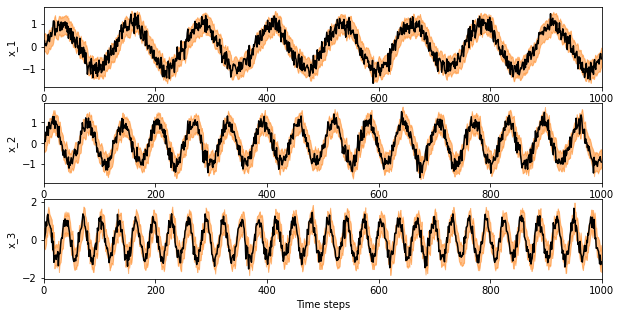

In [6]:
p_x = ssm_em1.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = p_x.mu[:,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

We can also make predictions, when we delete parts of the data.

In [33]:
X_test = numpy.copy(X)
X_test[numpy.random.rand(*X_test.shape) < .9] = numpy.nan
filter_test, mu, std = ssm_em1.predict(X_test, smoothed=True)

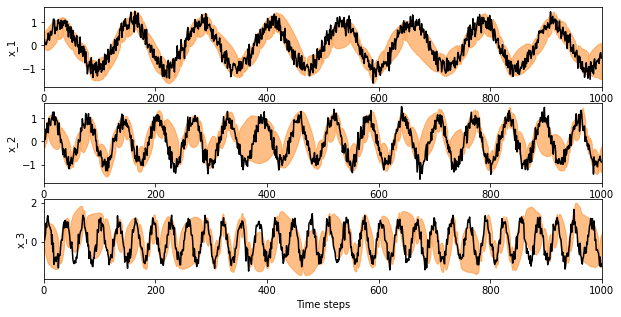

In [34]:
p_x = ssm_em1.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = mu[:,ix] - 1.68 * std[:,ix]
    x_max = mu[:,ix] + 1.68 * std[:,ix]
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()pyplot

# State space model with non linear transition mean

Now we do the same for a state-space model where the state model is non-linear.

In [57]:
Dk = 4
Dz = 3
# Below is the only line, that changes!
sm = state_models.LSEMStateModel(Dz, Dk, noise_z)
om = observation_models.LinearObservationModel(Dx, Dz, noise_x)
om.pca_init(X)

In [58]:
ssm_em = StateSpaceEM(X, observation_model=om, state_model=sm)

Iteration 10 - llk=-124.6
Iteration 20 - llk=-90.9
Iteration 30 - llk=-71.5
EM did converge.


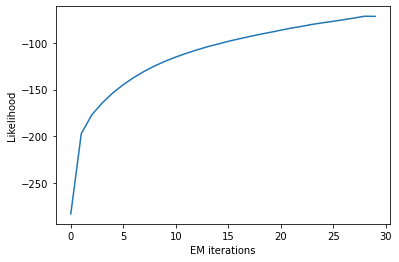

In [59]:
ssm_em.run()
pyplot.plot(ssm_em.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

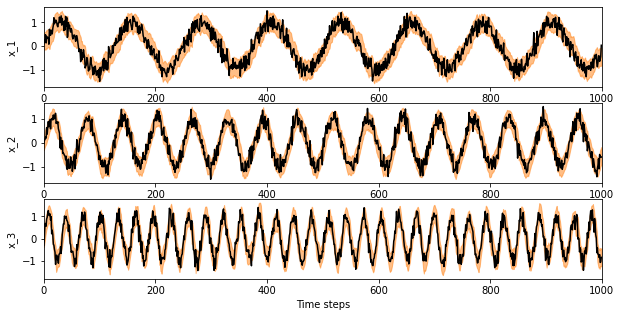

In [60]:
p_x = ssm_em.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)# State space model with non linear transition mean
    x_min = p_x.mu[:,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

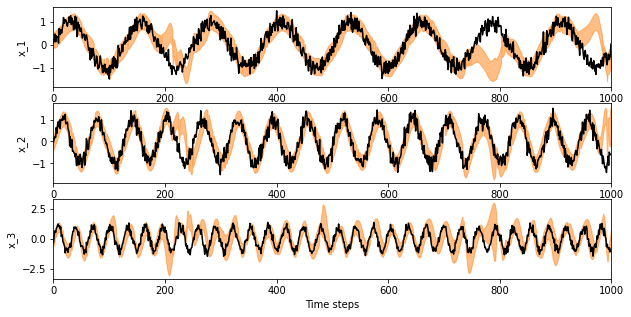

In [62]:
filter_test, mu, std = ssm_em.predict(X_test, smoothed=True)
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = mu[:,ix] - 1.68 * std[:,ix]
    x_max = mu[:,ix] + 1.68 * std[:,ix]
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

# Heteroscedastic State space model

And here we do the same again, but with linear transition model and heteroscedastic observation model.

In [9]:
Dk = 10
Dz = 3
Du = 2
sm = state_models.LinearStateModel(Dz, noise_z)
# Here we change the observation model.
om = observation_models.HCCovObservationModel(Dx, Dz, Du, noise_x=1.)
om.pca_init(X)
ssm_em = StateSpaceEM(X, observation_model=om, state_model=sm)

Iteration 10 - llk=-854.2
Iteration 20 - llk=-836.1
Iteration 30 - llk=-831.4
Iteration 40 - llk=-829.7
EM did converge.


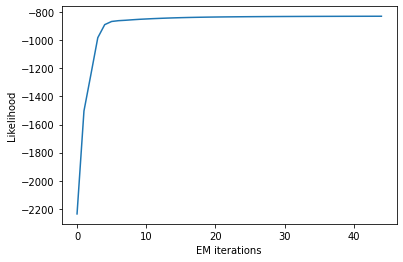

In [10]:
ssm_em.run()
pyplot.plot(ssm_em.llk_list[1:])
pyplot.xlabel('EM iterations')
pyplot.ylabel('Likelihood')
pyplot.show()

Text(0.5, 0, 'Time steps')

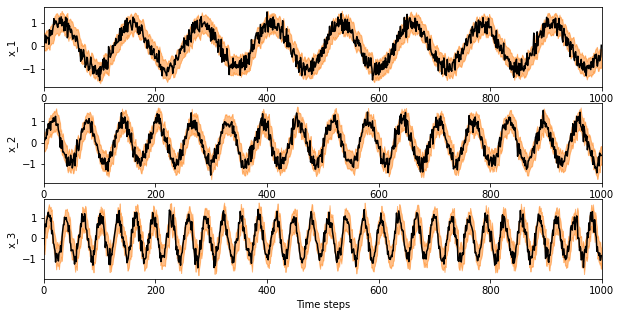

In [7]:
p_x = ssm_em.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = p_x.mu[:,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

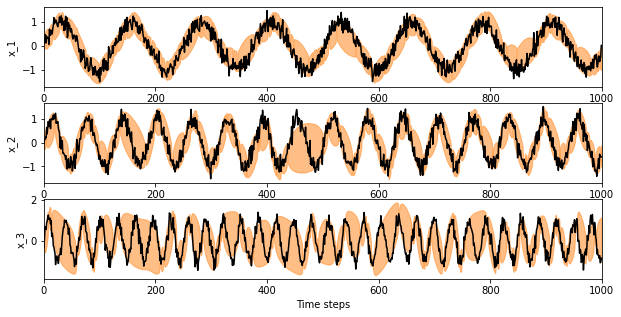

In [8]:
X_test = numpy.copy(X)
X_test[numpy.random.rand(*X_test.shape) < .9] = numpy.nan
filter_test, mu, std = ssm_em.predict(X_test, smoothed=True)
pyplot.figure(figsize=(10,5))
for ix in range(Dx):
    pyplot.subplot(Dx,1,ix+1)
    x_min = mu[:,ix] - 1.68 * std[:,ix]
    x_max = mu[:,ix] + 1.68 * std[:,ix]
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5)
    pyplot.plot(X[:,ix],'k')
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [7]:
numpy.arange(Dz)

array([0, 1, 2])